In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/train.csv')

X = df['message'].values
y = df['label'].values



Mounted at /content/drive
Loading data...


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Preprocessing function
# Preprocessing function
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    clean = re.compile('<.*?>')
    text = re.sub(clean, ' ', text)

    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#', '', text)

    # Remove punctuations and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove username pattern and hashtag
    tokens = [re.sub(r'\@\w+|\#', '', token) for token in tokens]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into a single string
    text = ' '.join(tokens)

    return text

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Ensure TensorFlow is using the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Apply preprocessing
df['processed_text'] = df['message'].apply(preprocess)
df['processed_text'] = df['processed_text'].replace('', np.nan)
df = df.dropna(subset=['processed_text'])

# Ensure binary classification
df['label'] = df['label'].map({'neg': 0, 'pos': 1})

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 100  # Adjust based on your data
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Train Word2Vec model
sentences = [text.split() for text in df['processed_text']]
w2v_model = Word2Vec(sentences, vector_size=200, window=10, min_count=2, workers=4, sample=0.001)

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 200))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [ ]:
model = Sequential([
    Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(124, return_sequences=True),
    LSTM(64),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

learning_rate = 0.0005
opt = Adam(learning_rate=learning_rate)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_pad, y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=5,
                    callbacks=[early_stopping])

# Testing
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/10
3200/3200 [==============================] - 50s 14ms/step - loss: 0.5437 - accuracy: 0.7377 - val_loss: 0.5013 - val_accuracy: 0.7807
Epoch 2/10
3200/3200 [==============================] - 43s 13ms/step - loss: 0.4546 - accuracy: 0.8075 - val_loss: 0.4630 - val_accuracy: 0.7728
Epoch 3/10
3200/3200 [==============================] - 43s 13ms/step - loss: 0.4111 - accuracy: 0.8284 - val_loss: 0.3375 - val_accuracy: 0.8612
Epoch 4/10
3200/3200 [==============================] - 43s 13ms/step - loss: 0.3518 - accuracy: 0.8563 - val_loss: 0.3149 - val_accuracy: 0.8710
Epoch 5/10
3200/3200 [==============================] - 43s 13ms/step - loss: 0.3223 - accuracy: 0.8649 - val_loss: 0.3064 - val_accuracy: 0.8745
Epoch 6/10
3200/3200 [==============================] - 43s 13ms/step - loss: 0.2944 - accuracy: 0.8799 - val_loss: 0.2976 - val_accuracy: 0.8795
Epoch 7/10
3200/3200 [==============================] - 43s 14ms/step - loss: 0.2632 - accuracy: 0.8959 - val_loss: 0.2980 -

157/157 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2446
           1       0.85      0.89      0.87      2554

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



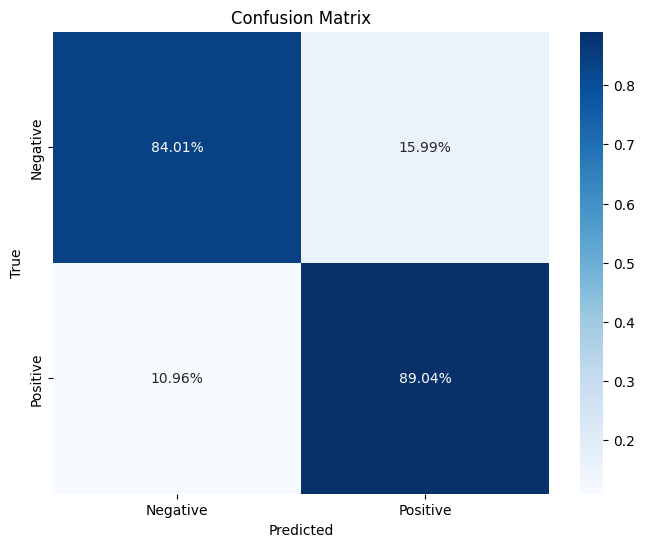

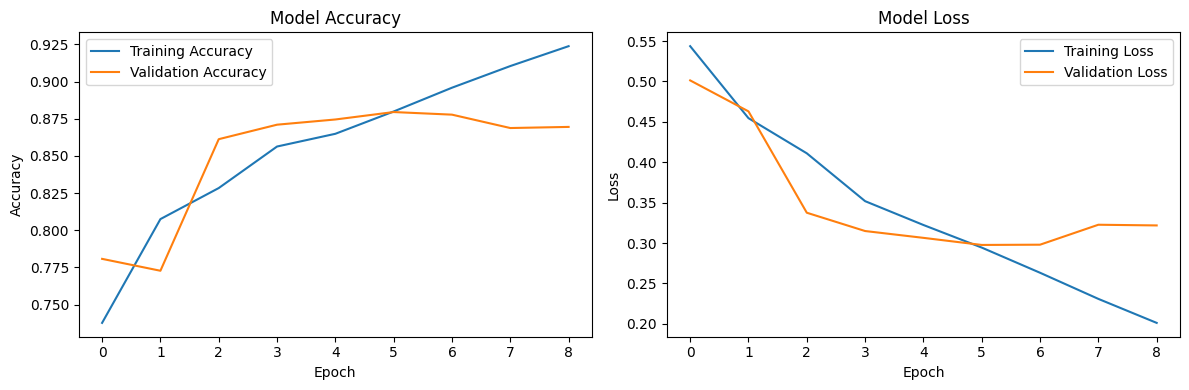

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

predictions = model.predict(X_test_pad)
binary_predictions = (predictions > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, binary_predictions))
cm = confusion_matrix(y_test, binary_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


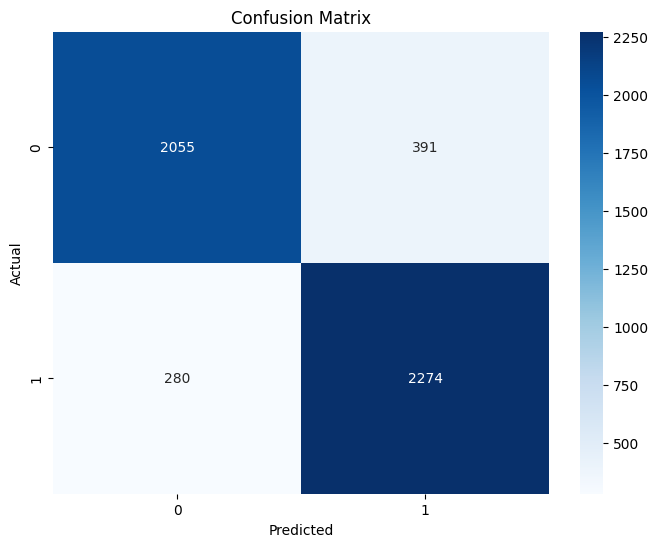

In [ ]:
cm = confusion_matrix(y_test, binary_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
test_df = pd.read_csv('/content/drive/My Drive/test.csv')
test_df['processed_text'] = test_df['message'].apply(preprocess)

X_test_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['processed_text']), maxlen=max_length, padding='post')

# Make predictions on test data
y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Convert numeric predictions to 'pos' and 'neg' labels
y_pred_labels = ['pos' if pred == 1 else 'neg' for pred in y_pred_classes]

# Create the submission DataFrame para el kaggle
submission_df = pd.DataFrame({
    'ids': range(len(y_pred_labels)),
    'label': y_pred_labels
})

submission_df.to_csv('/content/drive/My Drive/submission.csv', index=False)
print("Submission file saved to '/content/drive/My Drive/submission.csv'")

782/782 [==============================] - 5s 6ms/step
Submission file saved to '/content/drive/My Drive/submission.csv'
